In [2]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from adapters import *
from dataset import NumpyCsvDataSet
from runner import ExptRunner
from networks.autoencoder import AutoEncoder
from networks.composedautoencoder import ComposedAutoEncoder
from networks.DenseAutoEncoder import DenseAutoEncoder
from networks.ConvVae import ConvVae
from networks.vae import VAE
from networks.etpr.autoencoder import autoencoder as etprautoenc
from networks.dense import Dense
from networks.dense import DenseForPolicy
from networks.lossfunctions import *
from helpers import ReportResults
from policyeval import PolicyEvaluator
from policyeval import eval_policy_accuracy

In [4]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf)

In [5]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print (device)

cpu


In [5]:
start = time.time()
data_folder = 'data/demoplanner/version1'
v1_train_data = NumpyCsvDataSet(data_folder + '/train.csv', device=device)
v1_test_data = NumpyCsvDataSet(data_folder + '/test.csv', device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 32.92984127998352 sec


In [6]:
start = time.time()
data_folder = 'data/demoplanner/version2'
v2_train_data = NumpyCsvDataSet(data_folder + '/train.csv', device=device)
v2_test_data = NumpyCsvDataSet(data_folder + '/test.csv', device=device)
print ("Time Taken: {} sec".format(time.time() - start))

Time Taken: 364.81042313575745 sec


In [7]:
test_data = v2_test_data.data
train_data = v2_train_data.data

In [8]:
print (train_data.shape)
print (test_data.shape)

print (train_data.device)
print (test_data.device)

torch.Size([129779, 2058])
torch.Size([6648, 2058])
cpu
cpu


In [9]:
t_cpu = test_data.data.cpu()
start_indices = []
index = 0
while index < len(t_cpu):
    start_indices.append(index)
    start, goal = t_cpu[index, :2], t_cpu[index, 2:4]
    index += int(max(np.abs(goal - start)))
print (start_indices)
print (len(start_indices))

[0, 22, 31, 34, 43, 50, 70, 86, 90, 106, 114, 122, 138, 152, 157, 173, 184, 191, 211, 219, 224, 226, 249, 260, 269, 279, 290, 307, 324, 340, 355, 367, 376, 400, 412, 426, 436, 453, 474, 485, 489, 509, 530, 536, 545, 554, 579, 597, 608, 621, 643, 651, 656, 664, 676, 683, 692, 706, 713, 740, 759, 774, 792, 802, 819, 841, 853, 878, 898, 905, 914, 925, 934, 944, 954, 974, 984, 998, 1007, 1008, 1015, 1025, 1043, 1061, 1065, 1089, 1094, 1103, 1114, 1126, 1129, 1152, 1160, 1177, 1183, 1196, 1207, 1232, 1243, 1265, 1274, 1293, 1302, 1316, 1328, 1350, 1358, 1371, 1375, 1397, 1402, 1422, 1439, 1442, 1454, 1461, 1481, 1500, 1516, 1536, 1550, 1559, 1565, 1577, 1601, 1626, 1645, 1669, 1681, 1694, 1702, 1720, 1729, 1738, 1753, 1777, 1792, 1793, 1794, 1802, 1814, 1818, 1836, 1842, 1865, 1887, 1909, 1915, 1925, 1931, 1941, 1963, 1979, 1998, 2023, 2042, 2068, 2093, 2096, 2106, 2124, 2136, 2149, 2160, 2180, 2194, 2206, 2213, 2236, 2242, 2248, 2260, 2269, 2291, 2304, 2312, 2322, 2336, 2350, 2360, 2380, 2

In [17]:
policy = Dense([4, 16, 16, 6], use_last_act=False, prefix='enc')
policy.load_state_dict(torch.load('runs/04-08-10-24-50-Policy-V2-Dense-CE/autoenc.pth', map_location=device))

dynamics = Dense([4, 16, 2], prefix='enc')
dynamics.load_state_dict(torch.load('runs/03-31-18-02-52-Dynamics-V1-Dense-SmoothL1/autoenc.pth', map_location=device))

<All keys matched successfully>

In [19]:
print (eval_policy_accuracy(policy, test_data, device))
print (eval_policy_accuracy(policy, train_data, device))

tensor(1.)
tensor(1.)


In [12]:
finetuned_cp = torch.load('runs/04-13/run2/04-13-16-48-51-FineTunePolicyDynamics-V2-MultiNet-MSE/train_checkpoint.tar', map_location=device)
multinet = finetuned_cp['model']
policy = multinet.policy
dynamics = multinet.dynamics

/Users/pradeepkadubandi/.local/share/virtualenvs/DemoPlanner--5SJrBy7/lib/python3.6/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'networks.dense.Dense' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [13]:
print (policy)
print (dynamics)

Dense(
  (net): Sequential(
    (enc_fc0): Linear(in_features=4, out_features=16, bias=True)
    (enc_relu0): ReLU()
    (enc_fc1): Linear(in_features=16, out_features=16, bias=True)
    (enc_relu1): ReLU()
    (enc_fc2): Linear(in_features=16, out_features=6, bias=True)
  )
)
Dense(
  (net): Sequential(
    (enc_fc0): Linear(in_features=4, out_features=16, bias=True)
    (enc_relu0): ReLU()
    (enc_fc1): Linear(in_features=16, out_features=2, bias=True)
    (enc_sig1): Sigmoid()
  )
)


In [14]:
print (eval_policy_accuracy(policy, test_data, device))
print (eval_policy_accuracy(policy, train_data, device))

tensor(0.1247)
tensor(0.1215)


In [26]:
e = PolicyEvaluator(distance_func=F.l1_loss, policy=policy, dynamics=dynamics, 
                    using_grad_dynamics=True)

errors = torch.zeros((len(start_indices), 3))
for i in range(len(start_indices)):
    rstart = start_indices[i]
    rend = start_indices[i+1] if i < len(start_indices)-1 else len(t_cpu)
    trajectory = t_cpu[rstart:rend, :]
    goal_err, step_err, _, _, _, _ = e.eval_single_trajectory(trajectory)
    errors[i][0] = len(trajectory)
    errors[i][1] = goal_err
    errors[i][2] = step_err

In [27]:
print ('Trajectory with highest goal error = {}'.format(torch.argmax(errors[:, 1])))
print ('Trajectory with highest average step error = {}'.format(torch.argmax(errors[:, 2])))
print ('Trajectory Length, Goal Error, Average Error')
for i in range(len(errors)):
    print('{},{},{}'.format(*errors[i]))

Trajectory with highest goal error = 386
Trajectory with highest average step error = 386
Trajectory Length, Goal Error, Average Error
22.0,12.960399627685547,4.884669780731201
9.0,4.852686882019043,2.695817708969116
3.0,1.595874309539795,1.0638898611068726
9.0,5.459317684173584,2.786447286605835
7.0,6.841001033782959,3.9084365367889404
20.0,14.134435653686523,6.362017631530762
16.0,13.942781448364258,6.975234508514404
4.0,2.437255382537842,1.3359044790267944
16.0,9.144655227661133,4.250625133514404
8.0,5.237362861633301,2.5759902000427246
8.0,6.318533897399902,3.088604688644409
16.0,9.571662902832031,3.9311604499816895
14.0,10.939911842346191,4.983663082122803
5.0,4.435301780700684,2.461456537246704
16.0,9.867547988891602,4.4905571937561035
11.0,10.018267631530762,5.24059534072876
7.0,4.5808610916137695,2.244675636291504
20.0,16.234203338623047,7.611097812652588
8.0,4.736490249633789,2.309919834136963
5.0,4.173446178436279,2.204035520553589
2.0,1.3381853103637695,0.913787841796875
23.

In [23]:
traj_no = 386 
rstart = start_indices[traj_no]
rend = start_indices[traj_no+1] if traj_no < len(start_indices) else len(test_data)
trajectory = t_cpu[rstart:rend, :]
f = torch.cat((trajectory[:, :4], trajectory[:, 1028:1030]), dim=1)
print (len(f))
print (f)

25
tensor([[28., 27.,  3.,  4., -1.,  0.],
        [27., 27.,  3.,  4., -1.,  0.],
        [26., 27.,  3.,  4., -1., -1.],
        [25., 26.,  3.,  4., -1., -1.],
        [24., 25.,  3.,  4., -1., -1.],
        [23., 24.,  3.,  4., -1., -1.],
        [22., 23.,  3.,  4., -1., -1.],
        [21., 22.,  3.,  4., -1., -1.],
        [20., 21.,  3.,  4., -1., -1.],
        [19., 20.,  3.,  4., -1., -1.],
        [18., 19.,  3.,  4., -1., -1.],
        [17., 18.,  3.,  4., -1., -1.],
        [16., 17.,  3.,  4., -1., -1.],
        [15., 16.,  3.,  4., -1., -1.],
        [14., 15.,  3.,  4., -1., -1.],
        [13., 14.,  3.,  4., -1., -1.],
        [12., 13.,  3.,  4., -1., -1.],
        [11., 12.,  3.,  4., -1., -1.],
        [10., 11.,  3.,  4., -1., -1.],
        [ 9., 10.,  3.,  4., -1., -1.],
        [ 8.,  9.,  3.,  4., -1., -1.],
        [ 7.,  8.,  3.,  4., -1., -1.],
        [ 6.,  7.,  3.,  4., -1., -1.],
        [ 5.,  6.,  3.,  4., -1., -1.],
        [ 4.,  5.,  3.,  4., -1., -1.

In [24]:
goal_err, step_err, pred_traj, orig_traj, policy_pred, dyn_pred = e.eval_single_trajectory(trajectory)

print ('Last step error = {}'.format(goal_err))
print ('Average error over all steps = {}'.format(step_err))
print ('Original Trajectory and Predicted Trajectory:')
print (torch.cat((orig_traj, pred_traj), dim=1))
print ('Stepwise deviation from original trajectory:')
print (torch.abs(orig_traj-pred_traj))
print ('Prediction from Policy:')
print (policy_pred - 1.0) # Using minus to bring the policy output to the values we expect
print ('Prediction from Dynamics:')
print (dyn_pred * 2.0 - 1.0)  # Again bringing the dynamics prediction to the expected range

Last step error = 21.83930206298828
Average error over all steps = 10.87393569946289
Original Trajectory and Predicted Trajectory:
tensor([[27.0000, 27.0000, 27.8958, 26.9159],
        [26.0000, 27.0000, 27.7920, 26.8327],
        [25.0000, 26.0000, 27.6888, 26.7504],
        [24.0000, 25.0000, 27.5860, 26.6689],
        [23.0000, 24.0000, 27.4837, 26.5883],
        [22.0000, 23.0000, 27.3819, 26.5085],
        [21.0000, 22.0000, 27.2805, 26.4296],
        [20.0000, 21.0000, 27.1796, 26.3515],
        [19.0000, 20.0000, 27.0792, 26.2743],
        [18.0000, 19.0000, 26.9792, 26.1978],
        [17.0000, 18.0000, 26.8797, 26.1222],
        [16.0000, 17.0000, 26.7806, 26.0474],
        [15.0000, 16.0000, 26.6819, 25.9734],
        [14.0000, 15.0000, 26.5837, 25.9002],
        [13.0000, 14.0000, 26.4860, 25.8278],
        [12.0000, 13.0000, 26.3887, 25.7562],
        [11.0000, 12.0000, 26.2918, 25.6854],
        [10.0000, 11.0000, 26.1953, 25.6154],
        [ 9.0000, 10.0000, 26.0993, 25.54

In [8]:
map_netname_net = {
    'ComposedAutoEncoderWithMaxPool': lambda: ComposedAutoEncoder(useMaxPool=True),
    'DenseAutoEncoder3': lambda: DenseAutoEncoder(enc_layer_dims=[1024, 128, 16]),
    'ComposedAutoEncoderNoMaxPool': lambda: ComposedAutoEncoder(useMaxPool=False),
    'VAE': VAE,
    'ConvVAE': ConvVae,
    'EtprEncoder': etprautoenc,
    '03-31-18-02-15-Dynamics-V1-Dense-SmoothL1': lambda: Dense([4, 2]),
    '03-31-18-02-32-Dynamics-V1-Dense-SmoothL1': lambda: Dense([4, 8, 2]),
    '03-31-18-02-52-Dynamics-V1-Dense-SmoothL1': lambda: Dense([4, 16, 2]),
    '03-31-18-01-03-Dynamics-V1-Dense-MSE': lambda: Dense([4, 2]),
    '03-31-18-01-22-Dynamics-V1-Dense-MSE': lambda: Dense([4, 8, 2]),
    '03-31-18-01-50-Dynamics-V1-Dense-MSE': lambda: Dense([4, 16, 2]),
}     

In [11]:
rr = ReportResults(map_netname_net, device, 
                   dynamics_input_adapter, dynamics_gradient_ground_truth_adapter,
                   loss_adapter_func = l1_loss_adapter)

In [12]:
rr.generate_csv_comparison_report(test_data_float, train_data_float,
                   rootdir='runs/03-31')

Time,Goal,DataSet,Network,Loss(Training),TestLoss,TrainLoss
03:31:18:01:03,Dynamics,V1,Dense,MSE,0.0821070447564125,0.08388315141201019
03:31:18:01:22,Dynamics,V1,Dense,MSE,0.003344212891533971,0.0034352901857346296
03:31:18:01:50,Dynamics,V1,Dense,MSE,0.003786794375628233,0.003730030497536063
03:31:18:02:15,Dynamics,V1,Dense,SmoothL1,0.07136806100606918,0.07271932810544968
03:31:18:02:32,Dynamics,V1,Dense,SmoothL1,0.005948166828602552,0.006144481245428324
03:31:18:02:52,Dynamics,V1,Dense,SmoothL1,0.0032131331972777843,0.0033073569647967815


In [13]:
sample = torch.cat((test_data_float[1055:1060], test_data_float[1230:1235]), axis=0)
ground_truth = dynamics_gradient_ground_truth_adapter(sample).to(device)
for folder, net in rr.build_net(rootdir='runs/03-31/'):
    print ('Folder: ' + folder)
    op_batch, loss = rr.run_mini_batch(net, sample)
    print (ground_truth)
    print (op_batch)
    print (loss)
    print ('-----------------------------------------')

Folder: 03-31-18-01-03-Dynamics-V1-Dense-MSE
tensor([[0.0000, 0.5000],
        [0.0000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.5000]])
tensor([[0.1214, 0.5738],
        [0.1264, 0.1509],
        [0.0993, 0.4931],
        [0.1002, 0.4953],
        [0.1011, 0.4974],
        [0.9014, 0.1185],
        [0.9010, 0.1189],
        [0.9006, 0.1193],
        [0.9003, 0.1197],
        [0.9171, 0.5654]], grad_fn=<SigmoidBackward>)
tensor(0.0904, grad_fn=<MeanBackward0>)
-----------------------------------------
Folder: 03-31-18-01-22-Dynamics-V1-Dense-MSE
tensor([[0.0000, 0.5000],
        [0.0000, 0.0000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [0.0000, 0.5000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.0000],
        [1.0000, 0.5000]])
tensor([[0.0047, 0

In [19]:
rr = ReportResults(map_netname_net, device, 
                   policy_input_adapter, policy_groud_truth_adapter,
                   loss_adapter_func = l1_loss_adapter)

In [20]:
rr.generate_csv_comparison_report(test_data_float, train_data_float,
                   rootdir='runs/04-08')

Time,Goal,DataSet,Network,Loss(Training),TestLoss,TrainLoss
04:08:07:35:53,Policy,V2,Dense,MSE,0.0009246765985153615,0.0009788279421627522
04:08:07:29:36,Policy,V2,Dense,MSE,0.015583701431751251,0.016864705830812454


In [21]:
sample = torch.cat((test_data_float[1055:1060], test_data_float[1230:1235]), axis=0)
ground_truth = policy_groud_truth_adapter(sample).to(device)
for folder, net in rr.build_net(rootdir='runs/04-08/'):
    print ('Folder: ' + folder)
    op_batch, loss = rr.run_mini_batch(net, sample)
    print (ground_truth)
    print (op_batch)
    print (loss)

Folder: 04-08-07-35-53-Policy-V2-Dense-MSE
tensor([[-1.,  0.],
        [-1., -1.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1.,  0.]])
tensor([[-1.0000e+00, -5.9831e-04],
        [-9.9837e-01, -9.9866e-01],
        [-1.0000e+00, -2.0846e-03],
        [-1.0000e+00, -2.0014e-03],
        [-1.0000e+00, -1.9175e-03],
        [ 9.9764e-01, -9.9867e-01],
        [ 9.9765e-01, -9.9868e-01],
        [ 9.9766e-01, -9.9868e-01],
        [ 9.9767e-01, -9.9868e-01],
        [ 1.0000e+00,  7.1299e-04]], grad_fn=<TanhBackward>)
tensor(0.0012, grad_fn=<MeanBackward0>)
Folder: 04-08-07-29-36-Policy-V2-Dense-MSE
tensor([[-1.,  0.],
        [-1., -1.],
        [-1.,  0.],
        [-1.,  0.],
        [-1.,  0.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1., -1.],
        [ 1.,  0.]])
tensor([[-0.9994, -0.0311],
        [-0.9682, -0.9674],
        [-0.9995,  0.0176],
   

datapoint 0 test error tensor(9.2288e-06)


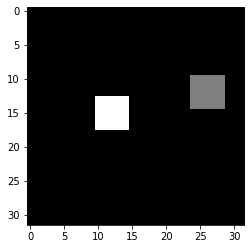

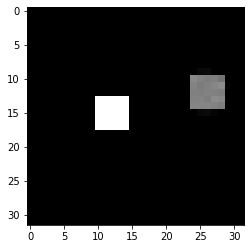

datapoint 1 test error tensor(9.4870e-06)


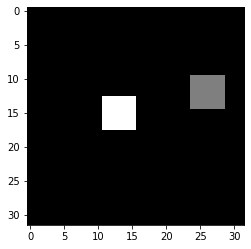

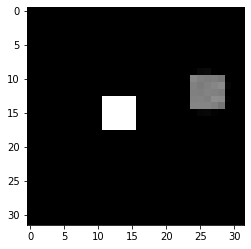

datapoint 2 test error tensor(1.5805e-05)


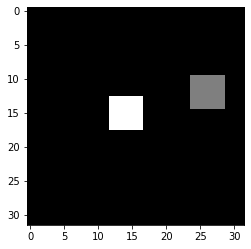

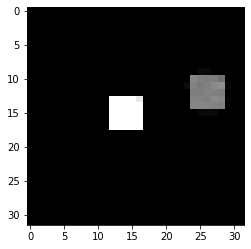

datapoint 3 test error tensor(1.1305e-05)


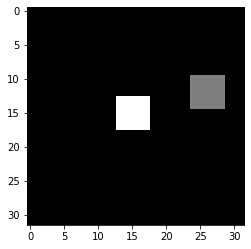

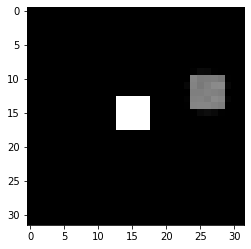

datapoint 4 test error tensor(1.3016e-05)


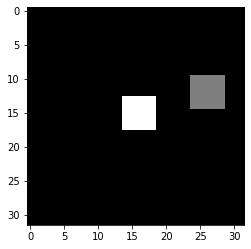

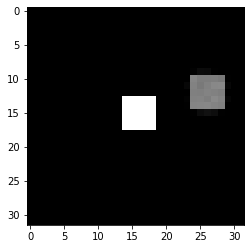

In [16]:
rr.show_test_samples(test_data_float,
                  rootdir='runs/03-28/03-28-14-10-20-DemoPl-V2-ComposedAutoEncoderWithMaxPool-SmoothL1-')

In [ ]:
np.set_printoptions(**opt)